## Single-output 20 class classification with synthetic dataset

In [24]:
from torch import Tensor
### import Necessary packages
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/')
from models_.lvmogp_svi import LVMOGP_SVI
from models_.variational_elbo import ClfVariationalELBO
from models_.momc_ar_likelihood import Multi_Output_Multi_Class_AR_Likelihood
import torch
from torch.optim.lr_scheduler import StepLR, CyclicLR
from tqdm import trange
import random
import numpy as np
import time
from util_functions import *
from typing import List, Dict
from sklearn.metrics import precision_score, recall_score, f1_score


In [8]:
### Copy from chunchao's code...
from sklearn.datasets import make_classification as mc

X1, Y1 = mc(n_samples=2000, n_classes=20, n_features=5, n_redundant=0, n_informative=5, n_clusters_per_class=1,
                    random_state=1)
X = X1.copy()
Y = Y1[:, None].copy()

In [9]:
train_test_split = 1300
X_train, X_test = Tensor(X[:train_test_split]), Tensor(X[train_test_split:])
Y_train, Y_test = Tensor(Y[:train_test_split]), Tensor(Y[train_test_split:])

In [10]:
print('The number of classes:', Y.max() - Y.min() + 1)
print('The number of train data samples:' , X_train.shape[0])
print('The number of test data samples:' , X_test.shape[0])
print('The number of features:', X_train.shape[-1])

The number of classes: 20
The number of train data samples: 1300
The number of test data samples: 700
The number of features: 5


In [11]:
# Define hyperparameters

clf_list = [20]
# NOTE
# len(clf_list) the total number of outputs
# clf_list[i] the number of classes for (i+1)th output
n_outputs = len(clf_list) # =1, only one output
n_latent = int(Tensor(clf_list).sum()) # NOTE n_outputs != n_latent for general cases
n_inputs = int(X_train.shape[0])
index_dim = X_train.shape[-1] # this is 5
latent_dim = 2
n_inducing_inputs = 10
n_inducing_latent = 3
pca = False # Think carefully when setting this to True
n_total= n_outputs * n_inputs

n_train_iterations = 300 # 1000
learning_rate = 0.5
schduler_step_size = 50
schduler_gamma = 0.9
num_latent_MC = 3

num_class_per_output = 10
num_input_samples = 300

In [12]:
# Specify model, likelihood and training objective.
my_model = LVMOGP_SVI(n_X=n_latent, n_C=n_inputs, index_dim=index_dim, latent_dim=latent_dim, n_inducing_C=n_inducing_inputs, n_inducing_X=n_inducing_latent, data_Y=None, pca=pca)
likelihood = Multi_Output_Multi_Class_AR_Likelihood(clf_list)
mll = ClfVariationalELBO(likelihood, my_model, num_data=n_total)

# Optimizer and Scheduler
optimizer = torch.optim.Adam([ # TODO: tune the choice of optimizer: SGD...
    {'params': my_model.parameters()}], lr=learning_rate)

# scheduler = CyclicLR(optimizer, base_lr=0.01, max_lr=0.5, step_size_up=20, mode='triangular', cycle_momentum=False)
scheduler = StepLR(optimizer, step_size=schduler_step_size, gamma=schduler_gamma)

In [13]:
# print(my_model.X.q_log_sigma.detach().exp())

In [14]:
def clf_sample_f_index_everyoutput(my_model, clf_list:List, labels:Tensor, num_class_per_output=5, num_input_samples:int=100, re_index_latent_idxs=True):
    '''
    After feeding (all_outputs, all_classes, all_inputs, index_dim) of inputs, we will get f of shape (all_outputs, all_classes, all_inputs).
    This function subsamples indices of f.
    All outputs are preserved, only classes and inputs are subsampled.
    Args:
        my_model: an instance of LVMOGP_SVI, _get_batch_idx function is in use.
        clf_list: list of n_classes. for example, [20, 13, 17] means 3 outputs with 20, 13, 17 classes respectively.
        labels: of shape (n_inputs, n_outputs). labels[a][b] extracts the classification label for a+1 th input at b+1 th output. 
        num_class_per_output: how many classes we want during subsampling.
            TODO: different output has different num of classes
        num_input_samples: how many data samples we want duing subsampling.

    Return:
        batch_index_latent: of shape (num_outputs, num_class_per_output+1, num_input_samples)
        batch_index_inputs: of shape (num_outputs, num_class_per_output+1, num_input_samples)
    NOTE: 
        1. Same set of inputs for every output.
        2. Same number of classes are downsampled for every output, seems unresonable if # total classes vary a lot across outputs.
        3. The final index on the second dim of batch_index_inputs is true label of the corresponding (input, output) pair which is useful in the future.
    '''

    num_outputs = len(clf_list)
    input_samples = Tensor(my_model._get_batch_idx(num_input_samples, sample_X = False)).to(int)

    final_inputs_idxs = input_samples.unsqueeze(0).unsqueeze(0)
    final_inputs_idxs = final_inputs_idxs.expand(num_outputs, (num_class_per_output+1), num_input_samples)

    final_latent_idxs = torch.zeros(num_outputs, (num_class_per_output+1), num_input_samples)

    for i in range(num_input_samples):
        for j in range(num_outputs):
            curr_true_label_idx = int(labels[input_samples[i], j]) # classification label for i+1 th input at j+1 th output ; labels[final_inputs_idxs[j,0,i]][j]
            num_class_curr_output = clf_list[j]
            available_range = list(np.arange(num_class_curr_output)[np.arange(num_class_curr_output) != curr_true_label_idx]) 
            assert len(available_range) == num_class_curr_output - 1
            curr_class_idx_list = random.sample(available_range, num_class_per_output)
            curr_class_idx_list.append(curr_true_label_idx) # of length num_class_per_output + 1
            assert len(curr_class_idx_list) == num_class_per_output + 1
            
            final_latent_idxs[j,:,i] = Tensor(curr_class_idx_list)
    
    assert final_inputs_idxs.shape == final_latent_idxs.shape

    if not re_index_latent_idxs:
        return final_latent_idxs.to(int), final_inputs_idxs
    
    # Transform idx properly to better match slicing functionality from my_model.sample_latent_variable()
    # as 
    else:
        counter = 0
        for j in range(num_outputs):
            final_latent_idxs[j,...] += counter
            counter += clf_list[j]
        return final_latent_idxs.to(int), final_inputs_idxs


## Initialization

## Training

In [15]:
# Training!
loss_list = []
iterator = trange(n_train_iterations, leave=True)

my_model.train()
for i in iterator: 
    batch_index_latent, batch_index_inputs = clf_sample_f_index_everyoutput(my_model, clf_list, Y_train, num_class_per_output=num_class_per_output, num_input_samples=num_input_samples)
    # core code is here 
    optimizer.zero_grad()
    total_loss = 0
    for _ in range(num_latent_MC):
        sample_latent = my_model.sample_latent_variable(batch_index_latent) 
        sample_inputs = X_train[batch_index_inputs]
        output_batch = my_model(sample_latent.reshape(-1,latent_dim), sample_inputs.reshape(-1,index_dim)) # q(f)
        loss = -mll(output_batch, ref=batch_index_latent)
        total_loss += loss
    
    average_loss = total_loss / num_latent_MC
    loss_list.append(average_loss.item())
    iterator.set_description('Loss: ' + str(float(np.round(average_loss.item(),2))) + ", iter no: " + str(i))
    average_loss.backward()
    
    # Gradient Clipping. Try Many Different Approaches.
    gradient_clip(my_model, approach='Global Norm Clipping', clip_value=5)
    # gradient_clip(likelihood, clip_value=1)
    
    optimizer.step()
    scheduler.step()

Loss: 0.31, iter no: 299: 100%|██████████| 300/300 [01:54<00:00,  2.61it/s]


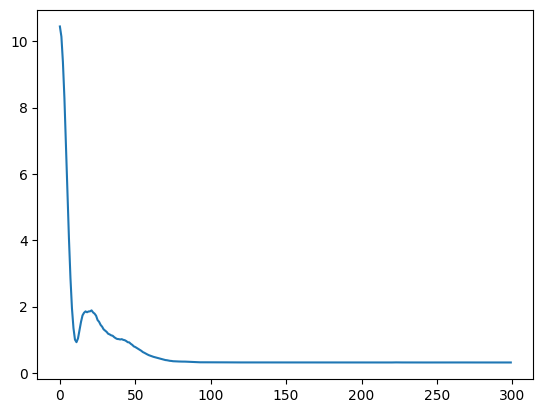

In [16]:
import matplotlib.pyplot as plt

plt.plot(loss_list)

## Testing

In [17]:
# my_model.X.q_mu.detach()
# my_model.X.q_log_sigma.detach().exp()

In [18]:
def Softmax_function(f_mean:Tensor, f_var:Tensor, num_MC_samples:int=50):
    '''
    Single output softmax funciton, i.e., given latent parameter values, we get probabilities for each class.
    The reparametrization trick is in use for Monte Carlo estimation ... 
    The methodology is from paper:
        <Scalable Gaussian Process Classification With Additive Noise for Non-Gaussian Likelihoods> 2022, Liu et al.
    
    Args:
        f_mean: of shape (n_test_samples, n_classes)
        f_var: of shape (n_test_samples, n_classes)
    
    Return:
        results_prob_mean: of shape (n_test_samples, n_classes)
        results_prob_var: of shape (n_test_samples, n_classes)
        results_decisions: of shape (n_test_samples)
        results_decisions_var: of shape (n_test_samples)
    '''
    n_test_samples, n_classes = f_mean.shape[0], f_mean.shape[1]
    # reparametrization trick for MC estimation!
    sample_f = f_mean.unsqueeze(-1).expand(-1, -1, num_MC_samples) + f_var.sqrt().unsqueeze(-1).expand(-1, -1, num_MC_samples) + torch.randn(n_test_samples, n_classes, num_MC_samples)
    assert sample_f.shape == torch.Size([n_test_samples, n_classes, num_MC_samples])
    exp_sample_f_term = sample_f.exp()
    exp_sample_f_sum_term = exp_sample_f_term.sum(1).unsqueeze(1).expand(-1, n_classes, -1) # sum over n_classes, then expand to proper size (for future use)
    softmax_ratios = exp_sample_f_term / exp_sample_f_sum_term

    results_prob_mean = softmax_ratios.mean(-1)
    results_prob_var = softmax_ratios.var(-1)
    results_decisions = results_prob_mean.argmax(1)
    results_decisions_var = results_prob_var.sum(1)

    return results_prob_mean, results_prob_var, results_decisions, results_decisions_var  
    

In [19]:
def MOMOC_predict(my_model, X_test:Tensor, clf_list:List, test_mini_batch:int=201, num_MC_samples:int=50, mode='All_Outputs'):
    '''
    MultiOutput MultiClass prediction given:
    Args:
        my_model: trained model.
        X_test: test input locations. of shape (n_test_samples, num_features).
        clf_list: list of # of classes (for every output). 
        mode: whether all output predictions of all test inputs are needed.
    Return:
        all_outputs_prob_mean, all_outputs_prob_var: List of tensors. length of List is n_outputs, shape of each tensor is (num_test_inputs, num_classes), num_classes might varies for different output.
        all_outputs_decisions, all_outputs_decisions_var: tensor of shape (n_test_samples, num_outputs)
    '''
    my_model.eval()
    n_outputs = len(clf_list)
    n_test_samples = X_test.shape[0]
    X_q_mu = my_model.X.q_mu.detach()
    n_latent = X_q_mu.shape[0]

    if mode == 'All_Outputs':

        # NOTE we would like two equal length 1d tensor for extracting elements in X_q_mu and X_test and feed them to my_model.
        # the length is n_latent * n_test_samples

        # ------------------------------------------------------------------------------------------------------------------------------
        # * we will get prediction results input by input. i.e. the first batch of outputs (of length n_latent) are for first test input, followed by
        # second input, third input and so on. 

        # * for first n_latent of prediction outputs, they are ordered task by task. i.e. first batch of them (of length clf_list[0]) are for first task,
        # followed by second task (of first input) and so on.

        # * by doing this, we may have very very long tensor which might not available for feeding into the model entirely at once. the solution here is
        # applying mini-batching ...
        # ------------------------------------------------------------------------------------------------------------------------------
        
        all_latent_index = Tensor(np.arange(n_latent)).repeat(n_test_samples)
        all_input_index = Tensor([i for i in range(n_test_samples) for _ in range(n_latent)])

        assert all_input_index.shape == all_latent_index.shape
        assert (all_latent_index[:n_latent]).var() != 0.0
        assert (all_input_index[:n_latent]).var() == 0.0 # all same elements

        test_mini_batch = test_mini_batch
        pred_results_mean = torch.zeros(int(n_latent * n_test_samples))
        pred_results_var = torch.zeros(int(n_latent * n_test_samples))
        test_continue = True
        start_idx = 0
        end_idx = test_mini_batch
        while test_continue:
            batch_latent = X_q_mu[all_latent_index[start_idx:end_idx].to(int)] # TODO: only mean are taken into consideration ...
            batch_inputs = X_test[all_input_index[start_idx:end_idx].to(int)]
            batch_output = my_model(batch_latent, batch_inputs) # q(f): batch prediction
            pred_results_mean[start_idx:end_idx] = batch_output.loc.detach()
            pred_results_var[start_idx:end_idx] = batch_output.variance.detach()
            # pred_results_mean.append(batch_output.loc.detach().tolist()) # This will leads to list of list, which is not desirable...
            # pred_results_var.append(batch_output.variance.detach().tolist())

            if end_idx < n_latent * n_test_samples:
                start_idx += test_mini_batch
                end_idx += test_mini_batch
                end_idx = min(end_idx, int(n_latent * n_test_samples))
            else:
                test_continue = False

        assert len(pred_results_mean) == len(pred_results_var) == int(n_latent * n_test_samples)
        
        pred_results_mean_tensor = Tensor(pred_results_mean).reshape(n_test_samples, n_latent)
        pred_results_var_tensor  = Tensor(pred_results_var).reshape(n_test_samples, n_latent)
        
        # NOTE: n_latent is the number of all latents for all outputs.
        # ------------------------------------------------------------------------------------------------------------------------------
        # We need to chunk pred_results_mean_tensor and pred_results_var_tensor into n_outputs tensors, each of them can be fed into previously defined
        # Softmax_function for getting predictions.
        # ------------------------------------------------------------------------------------------------------------------------------
        split_mean_tensors = torch.split(pred_results_mean_tensor, clf_list, dim=-1) # tuple of tensors
        split_var_tensors = torch.split(pred_results_var_tensor, clf_list, dim=-1)
        assert n_outputs == len(split_mean_tensors) == len(split_var_tensors)

        all_outputs_prob_mean = []
        all_outputs_prob_var = []
        all_outputs_decisions = torch.zeros(n_test_samples, n_outputs)
        all_outputs_decisions_var = torch.zeros(n_test_samples, n_outputs)


        for i in range(n_outputs):
            _prob_mean, _prob_var, _decisions, _decisions_var = Softmax_function(f_mean=split_mean_tensors[i], f_var=split_var_tensors[i], num_MC_samples=num_MC_samples)
            all_outputs_prob_mean.append(_prob_mean) # List of tensors
            all_outputs_prob_var.append(_prob_var)   # List of tensors
            all_outputs_decisions[:,i] = _decisions
            all_outputs_decisions_var[:,i] = _decisions_var

    return all_outputs_prob_mean, all_outputs_prob_var, all_outputs_decisions, all_outputs_decisions_var

In [28]:
def MOMC_classification_eval(predictions:Tensor, labels:Tensor) -> Dict[str, List[float]]:
    '''
    This function evaluate classification performance for every output given predictions tensor and labels tensor.
    
    Evaluation metrices are: precisions weighted, recall weighted and F1 weighted.

    Args:
        predictions: Tensor of shape (num_samples, num_outputs)
        labels: Tensor of shape (num_samples, num_outputs)
    
    Return:
        eval_results: dictionary, keys: Precision_Weighted, Recall_Weighted, F1_weighted.
                    for each key, the dict contains a list of performance for all outputs.
    '''
    eval_results = {'Precision_Weighted': [], 'Recall_Weighted': [], 'F1_Weighted': []}  

    # Iterate through each output
    for output in range(labels.size(1)):
        # Extract predictions and labels for the current output
        preds = predictions[:, output]
        lbls = labels[:, output]

        # Calculate weighted metrics for the current output
        precision = precision_score(lbls, preds, average='weighted')
        recall = recall_score(lbls, preds, average='weighted')
        f1 = f1_score(lbls, preds, average='weighted')

        # Store the results
        eval_results['Precision_Weighted'].append(precision)
        eval_results['Recall_Weighted'].append(recall)
        eval_results['F1_Weighted'].append(f1)

    return eval_results

In [21]:
'''
for name, param in my_model.named_parameters():
    if 'variational_strategy.inducing' in name:
        print(name, param.size())
        print(param)
'''

"\nfor name, param in my_model.named_parameters():\n    if 'variational_strategy.inducing' in name:\n        print(name, param.size())\n        print(param)\n"

In [22]:
all_outputs_prob_mean, all_outputs_prob_var, all_outputs_decisions, all_outputs_decisions_var = MOMOC_predict(my_model, X_train, clf_list)

In [23]:
(1.0 * (all_outputs_decisions == Y_train)).mean()

tensor(0.0585)

In [29]:
eval_results = MOMC_classification_eval(all_outputs_decisions, Y_train)

In [30]:
eval_results

{'Precision_Weighted': [0.05823393716057524],
 'Recall_Weighted': [0.05846153846153846],
 'F1_Weighted': [0.0578988121943782]}